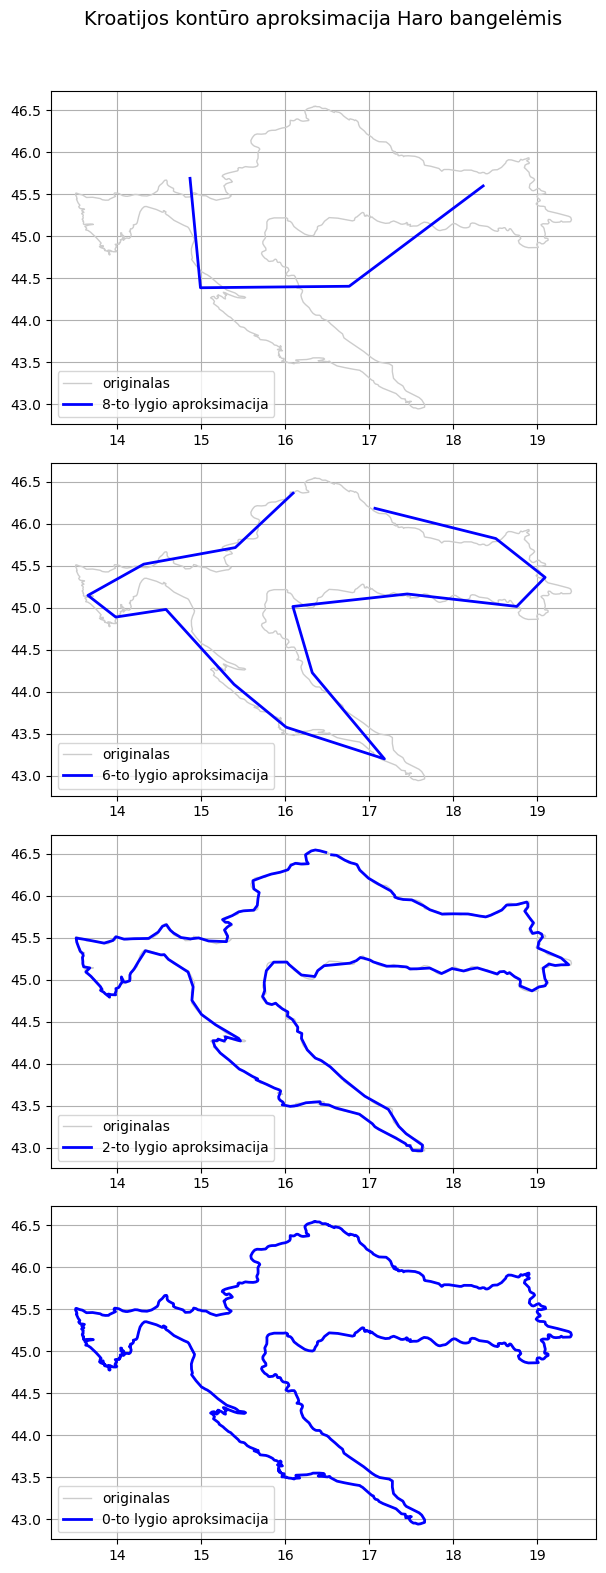

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import shapefile   # <-- vietoj geopandas

# ------------------------------------------------------------
# 1. PERSKAITOME KROATIJOS KONTŪRĄ IŠ LOKALAUS FAILO
# ------------------------------------------------------------
shp_path = "countries/ne_10m_admin_0_countries.shp"

sf = shapefile.Reader(shp_path)
records = sf.records()
shapes = sf.shapes()

# Surandame Kroatiją pagal ADMIN lauką
croatia_index = None
for i, rec in enumerate(records):
    if "Croatia" in rec:
        croatia_index = i
        break

if croatia_index is None:
    raise ValueError("Kroatijos įrašas nerastas shapefile!")

shape = shapes[croatia_index]

# Jei Kroatija turi daug poligonų – renkamės didžiausią
# (pyshp shape.parts atskiria poligonus)
parts = shape.parts
points = np.array(shape.points)

# Tik vieną didžiausią poligoną imame
if len(parts) > 1:
    lengths = []
    for i in range(len(parts)):
        start = parts[i]
        end = parts[i+1] if i < len(parts)-1 else len(points)
        lengths.append(end - start)

    largest_part = np.argmax(lengths)
    start = parts[largest_part]
    end = parts[largest_part + 1] if largest_part < len(parts)-1 else len(points)
    points = points[start:end]

# Kontūro x ir y
x = points[:, 0]
y = points[:, 1]

# ------------------------------------------------------------
# 2. NORMALIZUOJAME T → uniform parametras 0..1
# ------------------------------------------------------------
n = len(x)
t = np.linspace(0, 1, n)

# ------------------------------------------------------------
# 3. PIRAMIDINIS HARO WAVELET SKILIMAS
# ------------------------------------------------------------
def haar_decompose(sig):
    approximations = []
    details = []

    a = sig.copy()
    approximations.append(a)

    while len(a) > 1:
        # Dabartinio lygio ilgis
        n = len(a)
        # Skaičiuojame sekančio lygio aproksimacijas (vidurkius)
        a_next = (a[0:n:2] + a[1:n:2]) / np.sqrt(2)
        # Skaičiuojame sekančio lygio detales (skirtumus)
        d_next = (a[0:n:2] - a[1:n:2]) / np.sqrt(2)
        approximations.append(a_next)
        details.append(d_next)
        a = a_next

    return approximations, details


def haar_reconstruct(approximations, details, level):
    """
    Rekonstruoja signalą iš Haar koeficientų,
    išmetant smulkiausias detales.

    level = 0  -> pilna rekonstrukcija (visos detalės)
    level = 1  -> išmetame pačią smulkiausią detalę
    ...
    level = K  -> paliekame tik grubiausią aproksimaciją
    """

    # K – detalių lygių skaičius
    K = len(details)

    # Pradedam nuo grubiausios aproksimacijos (pats trumpiausias a_K)
    a = approximations[-1]

    # Einame nuo grubiausio lygio žemyn iki smulkiausio (0)
    for j in range(K-1, -1, -1):
        # Jei lygis mažesnis už nurodytą level – šią detalę anuliuojame
        if j < level:
            d = np.zeros_like(details[j])
        else:
            d = details[j]

        up = np.zeros(len(d)*2)
        # Į lyginius indeksus dedame (a + d)/sqrt(2)
        up[0::2] = (a + d)/np.sqrt(2)
        up[1::2] = (a - d)/np.sqrt(2)
        a = up

    return a

# ------------------------------------------------------------
# !! SVARBU: Haar reikalauja 2^k taškų
# ------------------------------------------------------------
def resample_to_power_of_two(x, y):
    n = len(x)
    # Randame didžiausią k, kad 2^k <= n
    k = int(np.floor(np.log2(n)))
    N = 2**k

    t_old = np.linspace(0, 1, n)
    t_new = np.linspace(0, 1, N)

    x_new = np.interp(t_new, t_old, x)
    y_new = np.interp(t_new, t_old, y)
    return x_new, y_new

x, y = resample_to_power_of_two(x, y)

# Skilimas
ax, dx = haar_decompose(x)
ay, dy = haar_decompose(y)

# ------------------------------------------------------------
# 4. PASIRENKI LYGĮS (detalumo)
# ------------------------------------------------------------
K = len(dx)

levels = [8, 6, 2, 0]
levels = [L for L in levels if L <= K]

plt.figure(figsize=(8, 16))
plt.suptitle("Kroatijos kontūro aproksimacija Haro bangelėmis", fontsize=14)

for i, L in enumerate(levels):
    Xr = haar_reconstruct(ax, dx, L)
    Yr = haar_reconstruct(ay, dy, L)
    plt.subplot(len(levels), 1, i+1)
    plt.plot(x, y, color='0.8', lw=1, label="originalas")
    plt.plot(Xr, Yr, '-b', lw=2, label=f"{L}-to lygio aproksimacija")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.legend(loc="best")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
#pip install pyshp